Neste Jupyter treinaremos nossa CNN com o dataset com crops que fizemos no jupyter criar_dataset_segmentado

In [1]:
#!pip install tf-nightly[and-cuda] pillow matplotlib kagglehub seaborn scikit-learn

In [2]:
import tensorflow as tf

I0000 00:00:1760286452.809064   54756 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1760286452.876236   54756 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1760286464.233339   54756 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Checando se o CUDA e GPU estão disponíveis

In [3]:
print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available())
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.21.0-dev20251009
Is built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1760286474.301157   54756 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1760286474.486543   54756 gpu_device.cc:2040] Created device /device:GPU:0 with 5181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080, pci bus id: 0000:01:00.0, compute capability: 12.0a
W0000 00:00:1760286474.487818   54756 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


Mostrando imagens do dataset apenas para ilustração

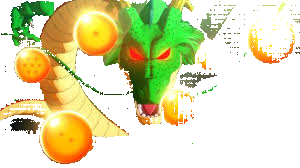

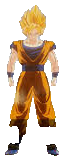

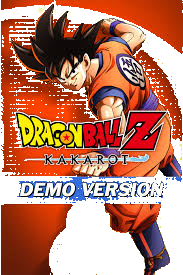

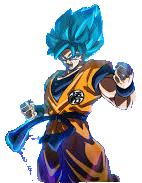

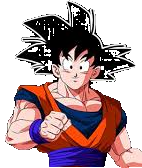

In [4]:
from PIL import Image
from IPython.display import display
import os

image_folder = "dataset_segmentado"

# Listar algumas imagens no diretório
for img_name in os.listdir(os.path.join(image_folder, 'Dragon Ball Z'))[:5]:
    img_path = os.path.join(image_folder, 'Dragon Ball Z', img_name)
    img = Image.open(img_path)
    display(img)

dataset_folder = image_folder


Verificando o shape do dataset, e se todas as imagens tem o mesmo tamanho

In [5]:
from collections import Counter

sizes = Counter()

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                with Image.open(img_path) as img:
                    sizes[(img.width, img.height)] += 1
            except Exception as e:
                print("erro em", img_path, e)

print("Shapes encontrados (width, height):")
for size, count in sizes.most_common():
    print(size, count)


Shapes encontrados (width, height):
(300, 168) 2
(183, 275) 2
(142, 168) 2
(225, 225) 2
(260, 194) 2
(64, 158) 1
(142, 183) 1
(111, 143) 1
(189, 252) 1
(140, 148) 1
(228, 168) 1
(98, 154) 1
(216, 162) 1
(66, 104) 1
(140, 157) 1
(173, 159) 1
(112, 133) 1
(144, 168) 1
(170, 225) 1
(142, 143) 1
(119, 162) 1
(107, 138) 1
(405, 124) 1
(190, 249) 1
(148, 189) 1
(175, 225) 1
(181, 168) 1
(329, 153) 1
(161, 164) 1
(79, 151) 1
(200, 252) 1
(164, 308) 1
(177, 194) 1
(284, 168) 1
(121, 267) 1
(121, 212) 1
(115, 165) 1
(180, 280) 1
(225, 217) 1
(83, 223) 1
(251, 201) 1
(205, 245) 1
(265, 190) 1
(202, 250) 1
(98, 166) 1
(163, 168) 1
(184, 194) 1
(75, 161) 1
(67, 161) 1
(55, 157) 1
(97, 225) 1
(132, 200) 1
(259, 195) 1
(179, 225) 1
(215, 172) 1


Vamos tentar criar as labels a partir da estrutura de folders do dataset utilizando um pre-processor do keras

In [6]:
from keras.preprocessing import image_dataset_from_directory
target_image_shape = (200, 200)

train_ds:tf.data.Dataset = image_dataset_from_directory(
    dataset_folder,
    image_size=target_image_shape,
    batch_size=32,
    label_mode="categorical"  # "int" / "binary" também possíveis
)

Found 60 files belonging to 2 classes.


W0000 00:00:1760286474.664974   54756 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1760286474.665167   54756 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [7]:
print(train_ds.class_names)

['Dragon Ball Z', 'Samurai X']


Criaremos um modelo teste abaixo para treinar a IA para detectar as imagens!

In [8]:
from keras import layers, models


modelo = models.Sequential([
    layers.Input(shape=(*target_image_shape, 3)),
    layers.Rescaling(1.0/255.0),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])


Agora compilaremos o modelo para deixá-lo pronto para o treinamento

In [9]:
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    20,480,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,499,778 (78.20 MB)

 Trainable params: 20,499,778 (78.20 MB)

 Non-trainable params: 0 (0.00 B)

Abaixo, a parte mais demorada, treinando o modelo, com GPU para acelerar

Note que o image_train e image_test são tuplas e já contém as labels necessárias para o treinamento

In [10]:
from keras.callbacks import EarlyStopping

train_size = int(0.7 * len(train_ds))

image_train = train_ds.take(train_size)
image_test = train_ds.skip(train_size)

es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

with tf.device('GPU:0'):
    modelo.fit(image_train, 
               epochs=50, 
               validation_data=image_test,
               batch_size=32,
               callbacks=[es]
               )

Epoch 1/50


I0000 00:00:1760286477.044387   58597 service.cc:158] XLA service 0x7d7930031aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760286477.044418   58597 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5080, Compute Capability 12.0a
I0000 00:00:1760286477.064178   58597 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760286477.201826   58597 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1760286477.694977   58721 subprocess_compilation.cc:347] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_14', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5312 - loss: 0.7000

I0000 00:00:1760286480.199783   58597 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5312 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 2.0057
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5938 - loss: 2.3793 - val_accuracy: 0.4643 - val_loss: 13.1934
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4375 - loss: 13.4370 - val_accuracy: 0.5357 - val_loss: 3.2620
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4688 - loss: 4.0128 - val_accuracy: 0.5714 - val_loss: 2.6036
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5000 - loss: 2.4492 - val_accuracy: 0.4643 - val_loss: 4.0160
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4062 - loss: 4.4431 - val_accuracy: 0.4643 - val_loss: 1.9759
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5938 - loss: 1.8773 - val_accuracy: 0.5357 - val_loss: 0.5969
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6562 - loss: 0.7413 - val_accuracy: 0.8929 - val_loss: 0.3648
Epoch 9/

In [11]:
# Avaliação do modelo
loss, acc = modelo.evaluate(image_test)
print(f"A loss do modelo é {loss:.2f} e a ACC é {acc:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.2372
A loss do modelo é 0.24 e a ACC é 1.00


In [12]:
preds = modelo.predict(image_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  # Adicione isso se não estiver importado

In [14]:
# Extrair labels verdadeiras do dataset de teste
y_true = np.concatenate([labels for images, labels in image_test], axis=0)

I0000 00:00:1760286484.289834   54756 local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


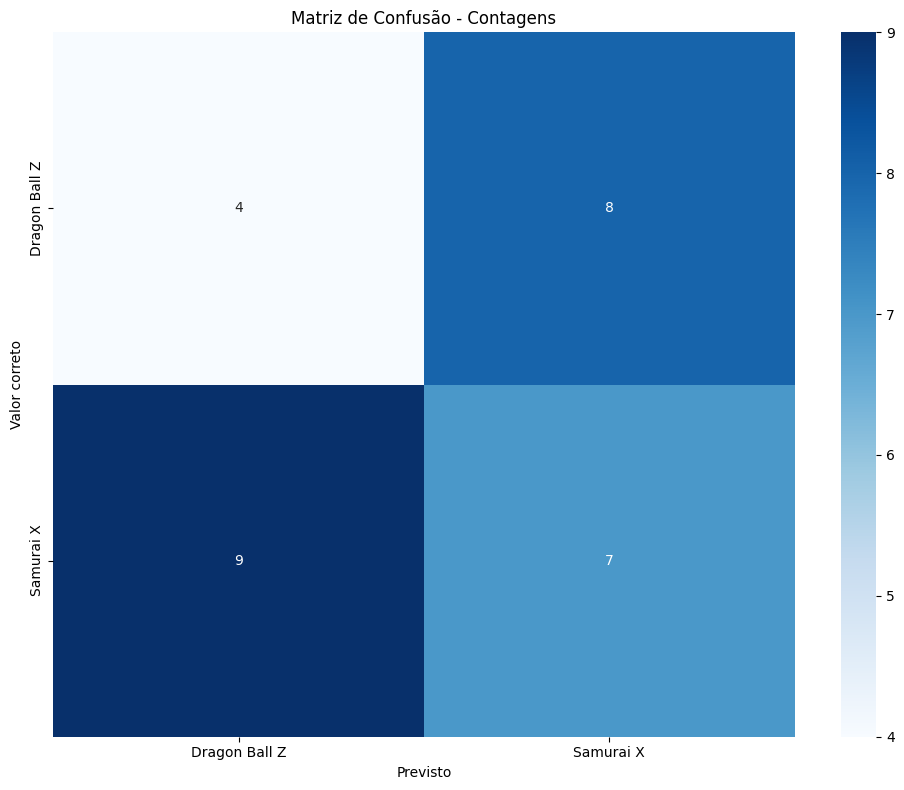

In [15]:
# Função para obter a matriz de confusão com nomes das classes
def plot_confusion_matrix(y_test, y_pred, class_names):
    labels = np.argmax(y_test, axis=1)
    labels_pred = np.argmax(y_pred, axis=1)
    cf_matrix = confusion_matrix(labels, labels_pred)
    
    # Normalizar para porcentagens (opcional, mas ajuda na visualização)
    cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(15, 15))  # Aumente o tamanho para acomodar muitas classes
    sns.heatmap(cf_matrix_normalized, annot=False, xticklabels=class_names, yticklabels=class_names, cmap='Blues')  # Remova annot para evitar rabiscos
    plt.xlabel('Previsto')
    plt.ylabel('Valor correto')
    plt.title('Matriz de Confusão Normalizada')
    plt.show()

def plot_confusion_matrix_counts(y_test, y_pred, class_names):
    """
    Plota matriz de confusão com contagens (número de previsões).
    y_test: one-hot ou categórico (a função assume one-hot e usa argmax)
    y_pred: probabilidades/one-hot preditas (usa argmax)
    """
    labels = np.argmax(y_test, axis=1)
    labels_pred = np.argmax(y_pred, axis=1)
    cf_matrix = confusion_matrix(labels, labels_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cf_matrix, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', cbar=True)
    plt.xlabel('Previsto')
    plt.ylabel('Valor correto')
    plt.title('Matriz de Confusão - Contagens')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_counts(y_true, preds, train_ds.class_names)

Percebemos aqui que o modelo teve um desempenho muito maior quando utilizamos o dataset segmentado, chegando a uma ACC de impressionantes 0,96!!!!